# Data Preparation 01

We need many images, representing each class of card. To achive this Goal I'm creating a movie of each card. Each movie is around 10" and during this time the card moves in front of the camera. The result will be a [MP4 File](https://de.wikipedia.org/wiki/MP4).

## How has the movie been taken
I made 2 runs on capturing movies with my Samsung S8. Please note that the card itself is using a photo glue in the back to be fixed on a geo triangle or paper stripe.
1. The first run was on 7.1 and the setup was not perfect. Everything went well. But it was a bad decision to have a wooden table as background. To improve it I decided later to run another scan.  
![Data Scan I](./images/diverse/datascan_i_kl.jpg)
2. The second run was made on the 22.1. Similar to the handy scan it was taken in front of the webcam. I used a special jupyter notebook for this type of scan. To switch to another card, I had to press space as it was defined by me in the jupyter notebook.  
![Data Scan II](./images/diverse/webbcamscan_ii_kl.jpg)
3. The third run was on 25.1. At this time I used a black background. I also payed attention to have better angle to the lying card.  
![Data Scan III](./images/diverse/datascan_iii_kl.jpg)



## Dataextraction for Datascan I & III (Movie related)

The next cell extracts all frames within a Movie into JPG images. Because of the big resolution of the movie (Full HD), we are going to scale the image by 40%. The generated JPG are stored in the filesystem.  

> Please Note: that we don't have to do anything on DataScan II, because they are already in the JPG format from the webcam capture.


In [1]:
import JassSummarizer as js
from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import shutil
import os
import cv2                                                              # computer vision python library see README.md dependencies
                                                                        
# define multiple scan input paths
pathList= [r".\images\02_data_preparation\datascan_i",r".\images\02_data_preparation\datascan_iii"]
OUTPUTPATH= r".\images\02_data_preparation\train_"
# iterate trough pathList
for path in pathList:
    setName=path.split("\\")[-1]
    outputPath=OUTPUTPATH+setName
    
    # generate a fileList of desired mp4 files
    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.mp4']

    # check availability of outputpath .. create if necessary
    if not os.path.exists(outputPath):
        os.mkdir(outputPath)

    if not os.path.exists(r".\images\02_data_preparation\train_datascan_iii\A0\A0_00000.jpg"):
        # iterate trough all movies
        for movie in fileList:
            cardId=movie.replace(path,"")[1:3]                                  # store the cardId from mvoviename the first 2 chars
            outputPathCard=os.path.join(outputPath,cardId)                      # generate outputPath per cardId
            if not os.path.exists(outputPathCard):                              # check if already there
                os.mkdir(outputPathCard)                                        # create if missing

            vidcap = cv2.VideoCapture(movie)                                    # open videostream
            success,image = vidcap.read()                                       # read first frame
            count = 0
            while success:
              outFile=os.path.join(outputPathCard,cardId+"_"+str(count).zfill(5)+".jpg")
              cv2.imwrite(outFile, js.scaleImage(image,40))                     # save frame as JPEG file with scaleFactor 40%
              success,image = vidcap.read()                                     # red next frame      
              count += 1
            #print(f"{cardId} {count}")                                          # print frame cout per cardId
            vidcap.release()                                                    # release videostream    

### Datascan reorganisation Datascan II (Webcam Capturing)
To put the datascan II to the same layout as the datascan I & III, we need to copy them to the appropriate folder and create the cardId folder structure.

In [2]:
path=r".\images\02_data_preparation\datascan_ii"
setName=path.split("\\")[-1]
outputPath=OUTPUTPATH+setName
# check availability of outputpath .. create if necessary
if not os.path.exists(outputPath):
    os.mkdir(outputPath)

if not os.path.exists(r".\images\02_data_preparation\train_datascan_ii\D8\D8_000033.jpg"):
    
    # generate a fileList of desired jpg files
    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

    for file in fileList:
        cardId=file.replace(path,"")[1:3]                                           # store the cardId from mvoviename the first 2 chars 
        outputPathCard=os.path.join(outputPath,cardId)                              # generate outputPath per cardId
        if not os.path.exists(outputPathCard):                                      # check if already there
            os.mkdir(outputPathCard)                                                # create if missing
        shutil.copyfile(file,os.path.join(outputPathCard,file.split("\\")[-1]))
    

### Statistics
The next cell shows some statistical information about the data.
* It shows for each scan a table Matrix with the count of Images. The lowest value is highlighted in yellow
* It shows a histogram for each datascan and its distribution of card type


,Eicheln,Schellen,Schilten,Rosen
type,,,,
N6,145,257,152,112
N7,123,191,196,71
N8,138,211,174,89
N9,171,159,207,66
Banner,162,186,231,75
Bauer,162,218,185,79
Ober,117,188,192,115
Koenig,148,186,159,99
Ass,122,208,138,69


,Eicheln,Schellen,Schilten,Rosen
type,,,,
N6,26,24,39,33
N7,19,23,34,30
N8,20,29,28,32
N9,32,30,34,30
Banner,34,31,31,30
Bauer,35,32,36,25
Ober,37,35,44,39
Koenig,32,36,41,35
Ass,26,38,40,34


,Eicheln,Schellen,Schilten,Rosen
type,,,,
N6,379,632,358,353
N7,428,443,392,375
N8,363,299,409,381
N9,422,366,339,328
Banner,464,298,405,374
Bauer,406,319,428,377
Ober,379,227,388,357
Koenig,393,364,410,369
Ass,405,357,561,356


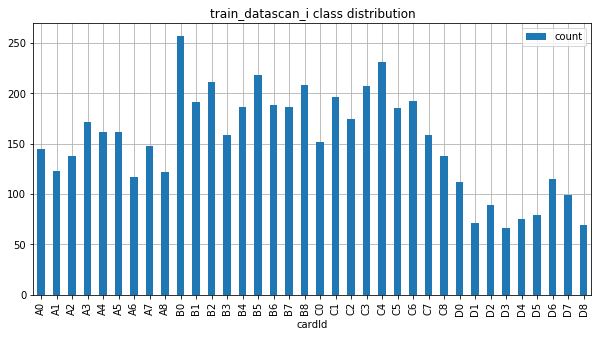

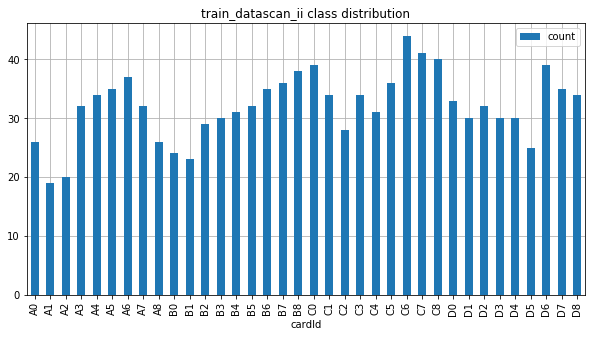

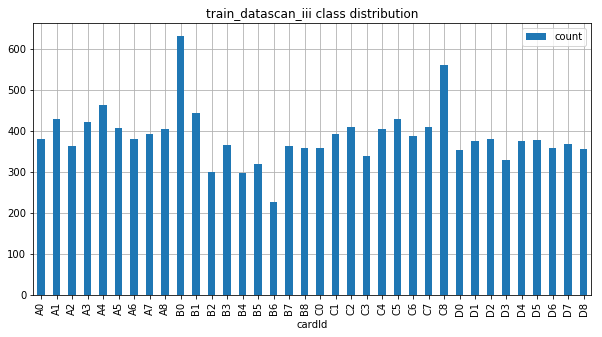

In [3]:
# define multiple scan input paths
pathList= [r".\images\02_data_preparation\train_datascan_i",r".\images\02_data_preparation\train_datascan_ii",r".\images\02_data_preparation\train_datascan_iii"]
# iterate trough pathList
for path in pathList:
    setName=path.split("_")[-1]
    display(HTML(f'<h3>Dataset {setName.upper()}</h3>'))


    fileList = [os.path.join(dp, f) for dp, dn, filenames in os.walk(path) for f in filenames if os.path.splitext(f)[1] == '.jpg']

    cardHistCount=np.zeros([1, len(js.JassCN2)],int).flatten()                          # define an emppty array with the length of the different card classes
    for item in fileList:                                                               # loop trough
        fName=item.split("\\")[-1]                                                      # get file name
        cardId=js.JassCN2[fName[0:2]].value                                             # parse cardId
        cardHistCount[cardId]=cardHistCount[cardId]+1                                   # increment cardId counter

    histogram=pd.DataFrame(cardHistCount,columns=["count"])                             # put data in pandas Dataframe for easy drawing
    histogram["cardId"]=js.JassCN2._member_names_                                       # add column with all card types
    histogram["a"]=histogram["cardId"].str.slice(start=1,stop=2)                        # create column a to store card names
    histogram["b"]=histogram["cardId"].str.slice(stop=1)                                # create column b to store card type

    t=pd.pivot_table(histogram,values="count",index=["a"],columns=["b"])                # create pivot representation
    t.columns=js.Jassmode._member_names_[0:4]                                           # include the types into columns
    t["type"]=js.JassCN._member_names_                                                  # include the card names into index
    t=t.set_index("type")                                                               # activate index
    t=t.style.apply(js.highlight_min, color='yellow', axis=None)                        # highlight lowest value
    display(t)

    histogram.plot.bar(x="cardId",y="count",grid=True,figsize=(10,5),title=path.split("\\")[-1]+" class distribution",zorder=10)
